In [1]:
# Load Libraries
import pandas as pd
import numpy as np

### Load Data

In [2]:
# Load data to a DataFrame
beanDF = pd.read_excel('DryBeanDataset/Dry_Bean_Dataset.xlsx')

In [3]:
# See the relative numbers of each target category
beanDF.value_counts('Class')

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
dtype: int64

In [4]:
df = beanDF.copy()

### Drop Features

#### Lowest Variance

In [5]:
## LOOK FOR FEATURES WITH LOW VARIANCE 
# (i.e. containing little information)

# Load libraries
from sklearn.feature_selection import VarianceThreshold

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Create thresholder
thresholder = VarianceThreshold(threshold=0.5)

# Create high-variance feature matrix
features_high_variance = thresholder.fit_transform(features)

# Look at features, sorted by variance (highest to lowest)
d = {'Column': beanDF.columns[:-1], 'Variance': thresholder.fit(features).variances_}
varianceDF = pd.DataFrame(d).sort_values('Variance', ascending=False)
varianceDF

,Column,Variance
6,ConvexArea,8.864805e+08
0,Area,8.598394e+08
1,Perimeter,4.591670e+04
2,MajorAxisLength,7.342954e+03
7,EquivDiameter,3.501674e+03
3,MinorAxisLength,2.022161e+03
4,AspectRation,6.084579e-02
14,ShapeFactor3,9.799518e-03
5,Eccentricity,8.463703e-03
11,Compactness,3.808272e-03


In [6]:
# Make a list of columns with variance less than 10e-4
low_var = varianceDF['Column'][(varianceDF['Variance'] < 1e-4)].tolist()
low_var

['Solidity', 'ShapeFactor4', 'ShapeFactor1', 'ShapeFactor2']

In [7]:
beanDF.drop(columns=low_var, inplace=True)
beanDF.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'roundness', 'Compactness', 'ShapeFactor3', 'Class'],
      dtype='object')

#### Highly Correlated

In [8]:
## LOOK AT HIGHLY CORRELATED FEATURES
# (i.e. likely to be redundant)

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Create correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                 k=1).astype(np.bool))

# Find index of feature columns with high correlation
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]

# Features to drop
print("Features with high correlation:\n", to_drop)

Features with high correlation:
 ['ConvexArea', 'EquivDiameter', 'ShapeFactor3']


In [9]:
beanDF.drop(columns=to_drop, inplace=True)
beanDF.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'Extent', 'roundness', 'Compactness',
       'Class'],
      dtype='object')

#### Most Informative

In [10]:
len(beanDF.columns)

10

In [11]:
## USE CHI-SQUARED TO FIND THE MOST INFORMATIVE FEATURES

# Load libraries
# from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectPercentile

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Select top 75% of features with highest F-values
fvalue_selector = SelectPercentile(f_classif, percentile=80)
features_kbest = fvalue_selector.fit_transform(features, target)

# Look at first row of best features
features_kbest[0]

array([2.83950000e+04, 6.10291000e+02, 2.08178117e+02, 1.73888747e+02,
       1.19719142e+00, 5.49812187e-01, 9.13357755e-01])

In [12]:
features.index

RangeIndex(start=0, stop=13611, step=1)

In [13]:
# Compare to first row of all features
features.iloc[0]

Area               28395.000000
Perimeter            610.291000
MajorAxisLength      208.178117
MinorAxisLength      173.888747
AspectRation           1.197191
Eccentricity           0.549812
Extent                 0.763923
roundness              0.958027
Compactness            0.913358
Name: 0, dtype: float64

In [14]:
# Check which features are in the kbest features
features.iloc[0].isin(features_kbest[0])

Area                True
Perimeter           True
MajorAxisLength     True
MinorAxisLength     True
AspectRation        True
Eccentricity        True
Extent             False
roundness          False
Compactness         True
Name: 0, dtype: bool

In [15]:
# Make a list of the low information features
low_inf = ['Extent', 'roundness']

In [16]:
# Drop low information features
beanDF.drop(columns=low_inf, inplace=True)
beanDF.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'Compactness', 'Class'],
      dtype='object')

### Histograms

In [17]:
# Load libraries
import matplotlib.pyplot as plt

In [18]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)

In [19]:
def makeHistogram(var, df=beanDF):
    # Create a histogram from a DataFrame variable
    plt.hist(df[var], bins=40)
    plt.xlabel(var, fontsize=20)
    plt.ylabel('Counts', fontsize=20)
    plt.tick_params(axis='both', labelsize=15)
    plt.show()

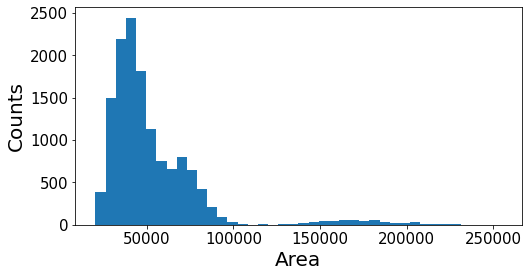

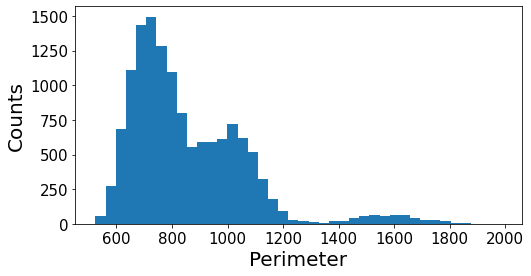

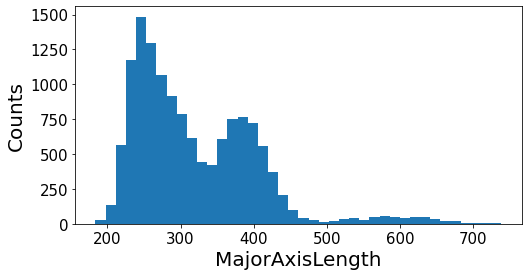

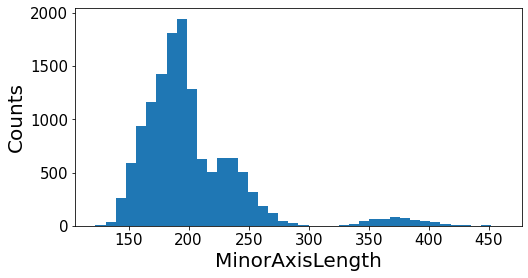

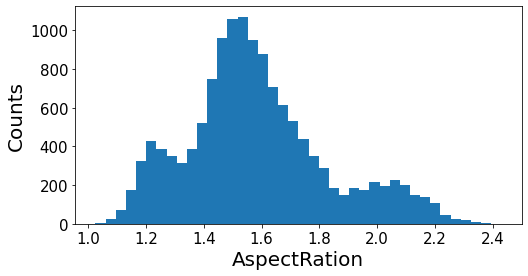

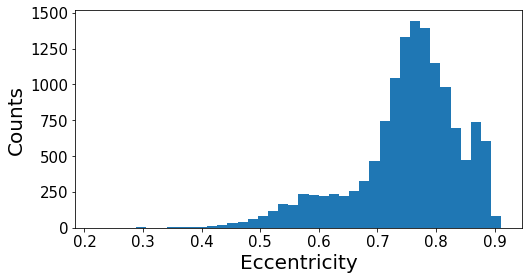

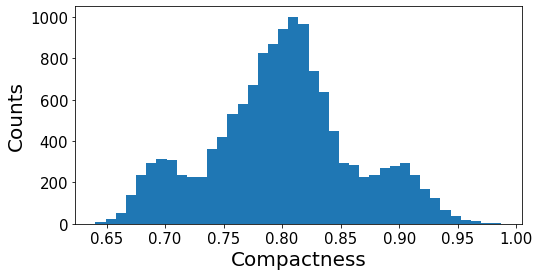

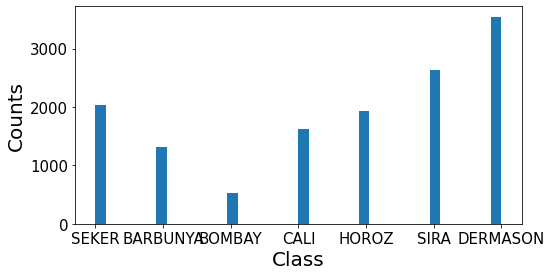

In [20]:
# Iterate through columns to get a quick look
# at the distribution of each variable
for item in beanDF.columns:
    makeHistogram(item)

### Transformations

#### Log(10)

In [21]:
# Create a new DataFrame for data transformations
transformDF = beanDF.copy()

In [22]:
# Features with large right skew (> 1)
transformDF.skew()[transformDF.skew() > 1]

Area               2.952931
Perimeter          1.626124
MajorAxisLength    1.357815
MinorAxisLength    2.238211
dtype: float64

In [23]:
# Get a list of the columns for log-transformation
pos_skew = transformDF.skew()[transformDF.skew() > 1].index.tolist()
pos_skew

['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength']

In [24]:
# Apply a log10-tranformation to right-skewed columns
for item in pos_skew:
    transformDF[item] = np.log10(transformDF[item])

#### 4th Power

In [25]:
# Features with large left skew (< -1)
transformDF.skew()[transformDF.skew() < -1]

Eccentricity   -1.062824
dtype: float64

In [26]:
# Get a list of the columns for cube tranformation
neg_skew = transformDF.skew()[transformDF.skew() < -1].index.tolist()
neg_skew

['Eccentricity']

In [27]:
# Apply a cube-tranformation to left-skewed columns
for item in neg_skew:
    transformDF[item] = transformDF[item]**4

In [28]:
transformDF

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,Compactness,Class
0,4.453242,2.785537,2.318435,2.240271,1.197191,0.091381,0.913358,SEKER
1,4.458396,2.804833,2.302168,2.261820,1.097356,0.028753,0.953861,SEKER
2,4.468052,2.795261,2.328025,2.245343,1.209713,0.100275,0.908774,SEKER
3,4.477237,2.810155,2.323372,2.261302,1.153638,0.061811,0.928329,SEKER
4,4.479143,2.792486,2.305024,2.279391,1.060798,0.012397,0.970516,SEKER
...,...,...,...,...,...,...,...,...
13606,4.624251,2.880640,2.460479,2.269384,1.552728,0.342492,0.801865,DERMASON
13607,4.624292,2.879382,2.449596,2.280381,1.476439,0.292960,0.822252,DERMASON
13608,4.624684,2.880425,2.449540,2.281461,1.472582,0.290361,0.822730,DERMASON
13609,4.624767,2.882968,2.452373,2.279383,1.489326,0.301579,0.817457,DERMASON


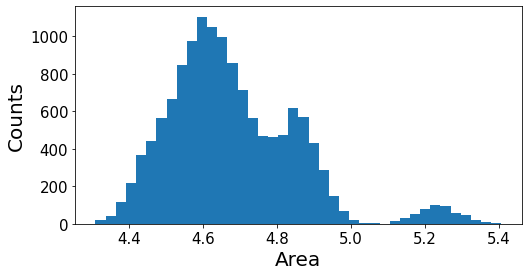

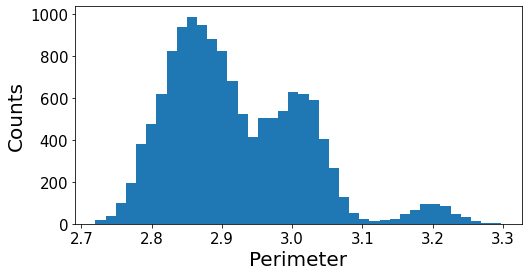

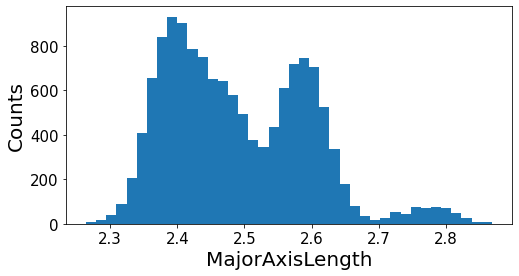

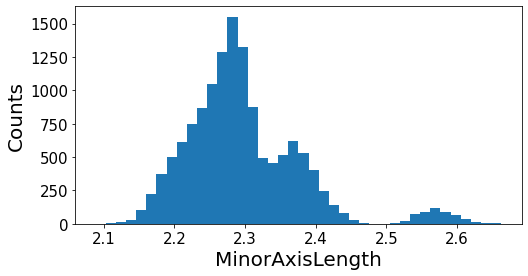

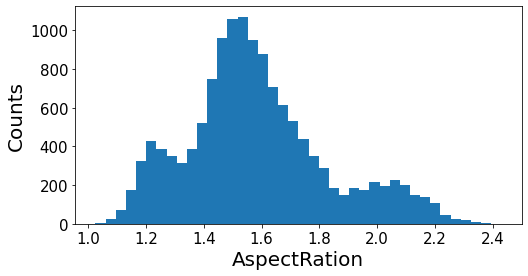

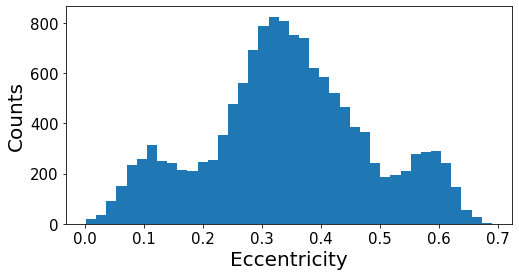

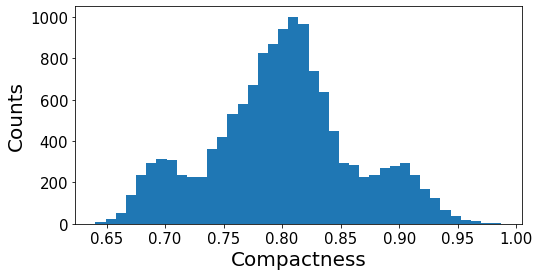

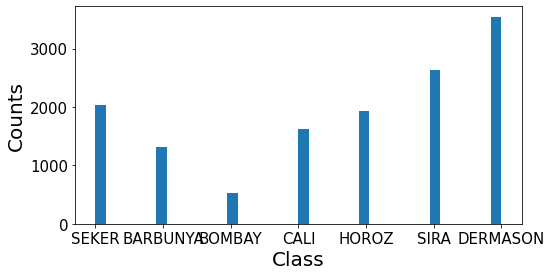

In [29]:
# Iterate through columns to get a quick look
# at the distribution of each variable
for item in transformDF.columns:
    makeHistogram(item, df=transformDF)